# Trilateración de posiciones

El *proceso de trilateración* es una forma de determinar la posición de un objeto conocida solamente su posición relativo a un conjunto de sensores y es una de las bases de como funcionan los sistemas de GPS. Aquí armaremos un sistema de trilateración en tres dimensiones asumiendo conocimiento perfecto de las mediciones. Asumiendo que conoce solamente la posición de los sensores y las mediciones realizadas, la posición de la partícula puede recuperarse resolviendo ecuaciones del tipo:

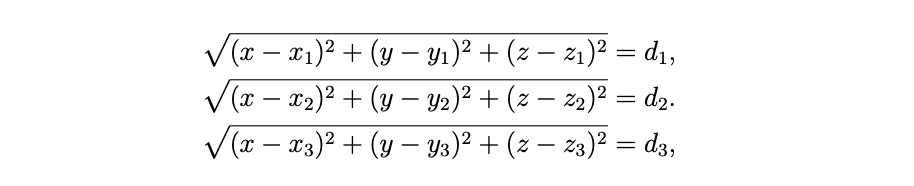

### Objetivo:
* Recuperar la trayectoria de la partícula resolviendo las ecuaciones de arriba mediante el método de Newton. 
* Interpolar las posiciones obtenidas para generar un trayectoria y compararlas con la trayectoria real (ground truth).

In [45]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

posicionSensores = [(10,0,0),(0,10,0),(0,0,10)]

In [46]:
def equations(vars, d1, d2, d3):
    x, y, z = vars
    eq1 = (x - 10)**2 + y**2 + z**2 - d1**2
    eq2 = (y - 10)**2 + x**2 + z**2 - d2**2
    eq3 = (z - 10)**2 + y**2 + x**2 - d3**2
    return np.array([eq1, eq2, eq3])

def jacobian(vars):
    x, y, z = vars
    J = np.array([
        [2 * (x - 10), 2 * y, 2 * z],
        [2 * x, 2 * (y - 10), 2 * z],
        [2 * x, 2 * y, 2 * (z - 10)]
    ])
    return J 

# Método de Newton-Raphson
def newton_raphson( d1, d2, d3, tol=1e-6, max_iter=100):
    rendimiento = []
    x = (0, 0, 0)  ## Armo mi punto inicial X0 

    for i in range(max_iter):
        
        #Itero
        F = equations(x, d1, d2, d3) ## Calculo F(x)

        #Evaluo X en el Jacobiano
        J = jacobian(x)
        
        # Resolver J * delta_x = -F(x) (esto sale de Xn+1 = Xn - J^-1 * F(x))
        delta_x = np.linalg.solve(J, -F)
        
        # Actualizar x (paso iterativo). Xn+1 = Xn + delta_x
        x = x + delta_x
        
        # Verificar la convergencia. Deberia tender a cero
        rendimiento.append((i,np.linalg.norm(delta_x)))

        if np.linalg.norm(delta_x) < tol:
            return x,rendimiento
    
    raise RuntimeError("El método de Newton-Raphson no convergió")

Tiramos sobre las medidas para obtener una posicion(t)

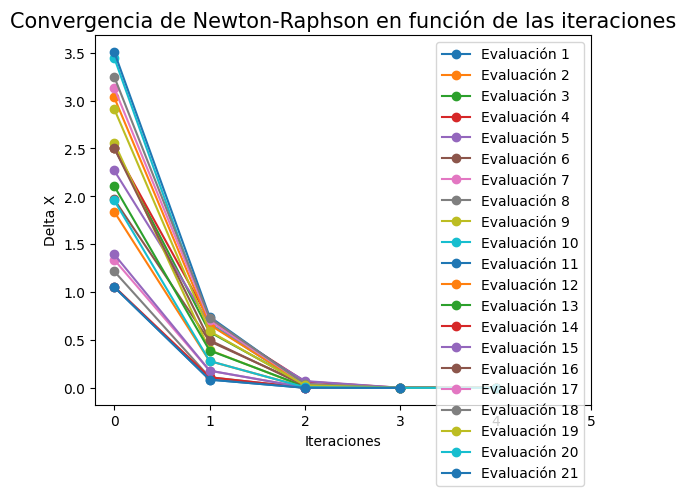

In [47]:
medidas = pd.read_csv('mnyo_tp01_datasets/medidas.csv',sep=';')

t = np.array(medidas.iloc[:,0])
posiciones_x = []
posiciones_y = []
posiciones_z = []
rendimiento = []
for i in range(len(medidas)):
    
    d1 = float(medidas.iloc[i,1])
    d2 = float(medidas.iloc[i,2])
    d3 = float(medidas.iloc[i,3])

    (x,y,z),perf = newton_raphson(d1, d2, d3)
    rendimiento.append(perf)
    
    posiciones_x.append(round(x,4)) #registro posición en cada eje
    posiciones_y.append(round(y,4))
    posiciones_z.append(round(z,4))

data0 = {
    't(s)': t,
    'X(m)': posiciones_x,
    'Y(m)': posiciones_y,
    'z(m)': posiciones_z,
}
df0 = pd.DataFrame(data0)

for idx, prueba in enumerate(rendimiento):

    iteraciones = [item[0] for item in prueba]
    delta_x = [item[1] for item in prueba]
    
    plt.plot(iteraciones, delta_x, label=f'Evaluación {idx+1}',marker='o')


plt.xlabel('Iteraciones')
plt.ylabel('Delta X')
plt.title('Convergencia de Newton-Raphson en función de las iteraciones',fontsize=15)
plt.legend(loc='upper right')
plt.xticks((0,1,2,3,4,5))
plt.show()

# guardamos DataFrame en un archivo CSV
df0.to_csv('posiciones relativas.csv', index=False)

In [48]:
def spline_cubicos(t, posiciones_x, posiciones_y, posiciones_z,config='not-a-knot'):
    """splines cúbicos para interpolar las posiciones en cada eje"""
    spline_x = CubicSpline(t, np.array(posiciones_x),bc_type=config)
    spline_y = CubicSpline(t, np.array(posiciones_y),bc_type=config)
    spline_z = CubicSpline(t, np.array(posiciones_z),bc_type=config)

    # nuevo conjunto de puntos de tiempo para la interpolación
    t_new = np.arange(min(t), max(t),0.01)
    t_new = np.append(t_new, 10)    
    t_new = np.round(t_new,2)

    # Interpolación
    x_new = spline_x(t_new) 
    y_new = spline_y(t_new)
    z_new = spline_z(t_new)

    return t_new, x_new, y_new, z_new

def plot_3d(t, xs, ys, zs, pos_x, pos_y, pos_z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plt.title('Trayectoria interpolada con splines cubicos')
    
    ax.plot(xs, ys, zs, label='Trayectoria interpolada', color='b')
    ax.scatter(np.array(pos_x), np.array(pos_y), np.array(pos_z), color='r', label='Posiciones trilateradas')
    
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.legend()
    plt.legend(loc='lower center')
    plt.show()

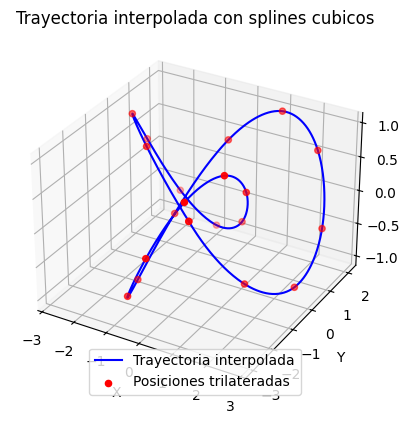

In [49]:
t_interpolado, tray_x_interpolado, tray_y_interpolado, tray_z_interpolado = spline_cubicos(t, posiciones_x, posiciones_y, posiciones_z)
plot_3d(t_interpolado, tray_x_interpolado, tray_y_interpolado, tray_z_interpolado, posiciones_x, posiciones_y, posiciones_z)

In [50]:
data = {
    't_interpolado': t_interpolado,
    'tray_x_interpolado': tray_x_interpolado,
    'tray_y_interpolado': tray_y_interpolado,
    'tray_z_interpolado': tray_z_interpolado
}
df = pd.DataFrame(data)
df.to_csv('trayectoria_interpolada.csv', index=False)

In [51]:
#Leemos la trayectoria
trayectoria_df = pd.read_csv('mnyo_tp01_datasets/trayectoria.csv',sep=';')

t_reales = np.array(trayectoria_df.iloc[:,0])

tray_x_real = np.array(trayectoria_df.iloc[:,1])
tray_y_real = np.array(trayectoria_df.iloc[:,2])
tray_z_real = np.array(trayectoria_df.iloc[:,3])

In [52]:
eval_errores = []
for i in range(len(t_reales)):
    
    error = np.linalg.norm([
    tray_x_real[i] - tray_x_interpolado[i],
    tray_y_real[i] - tray_y_interpolado[i],
    tray_z_real[i] - tray_z_interpolado[i]])

    eval_errores.append((t_reales[i], error))
    
# mediana del error 
errores_val = [error for t, error in eval_errores]
mediana_error = round(np.median(errores_val),5)

# error maximo
max_error = round(max(errores_val),5)

Gráficos de la trayectoria real y la interpolada en 3D

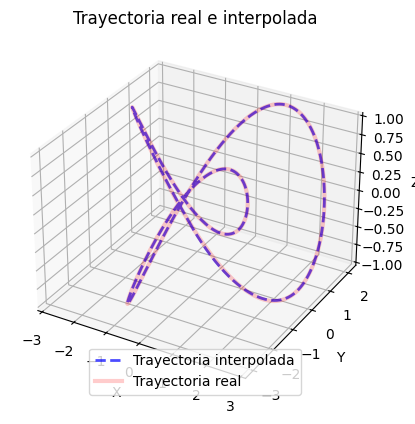

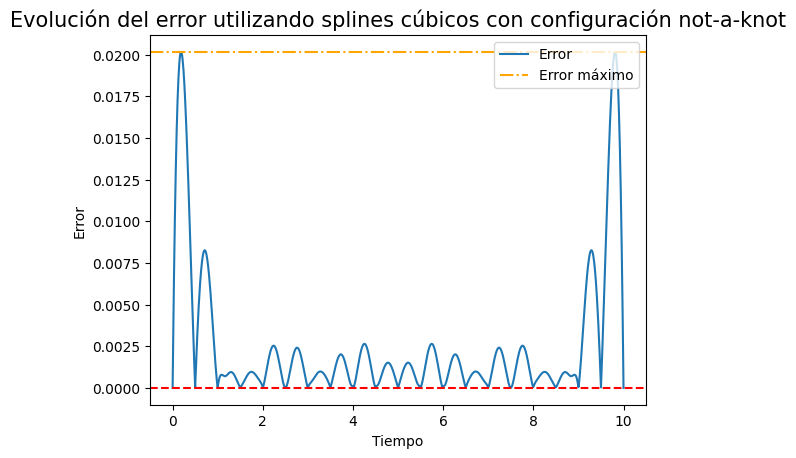

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plt.title('Trayectoria real e interpolada')

ax.plot(tray_x_interpolado, tray_y_interpolado, tray_z_interpolado, label='Trayectoria interpolada', color='b',linewidth=2,linestyle='--',alpha=0.7)
ax.plot(tray_x_real, tray_y_real, tray_z_real, label='Trayectoria real', color='r',linestyle='-',linewidth=3,alpha=0.2)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.legend(loc='lower center')
plt.show()
plt.title('Evolución del error utilizando splines cúbicos con configuración ''not-a-knot''', fontsize=15)

#G evolucion del error en el tiempo
t_eval, errores = zip(*eval_errores)
plt.plot(t_eval, errores, label='Error')

plt.xlabel('Tiempo')
plt.ylabel('Error')
plt.axhline(y=0, color='r', linestyle='--')

plt.axhline(y=max_error, color='orange', linestyle='-.', label='Error máximo')  # Asíntota en el error máximo

plt.legend()
plt.legend(loc='upper right')
plt.show()

### Configuracion Periodic

In [54]:
########################################## Configuracion Periodic ##########################################

data = {
    't_interpolado': t_interpolado,
    'tray_x_interpolado': tray_x_interpolado,
    'tray_y_interpolado': tray_y_interpolado,
    'tray_z_interpolado': tray_z_interpolado
}
df = pd.DataFrame(data)

# guardo el DataFrame en archivo CSV
df.to_csv('trayectoria_interpolada.csv', index=False)

In [55]:
trayectoria_df = pd.read_csv('mnyo_tp01_datasets/trayectoria.csv',sep=';')

t_reales = np.array(trayectoria_df.iloc[:,0])

tray_x_real = np.array(trayectoria_df.iloc[:,1])
tray_y_real = np.array(trayectoria_df.iloc[:,2])
tray_z_real = np.array(trayectoria_df.iloc[:,3])

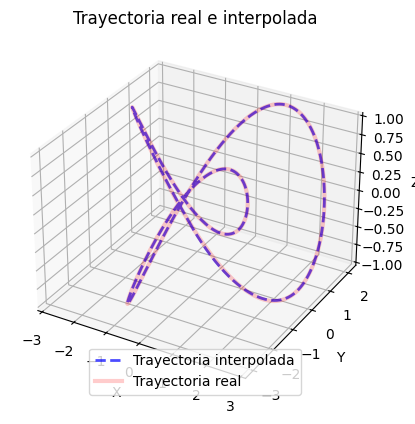

Text(0.5, 1.0, 'Evolución del error utilizando splines cúbicos con configuración periodic')

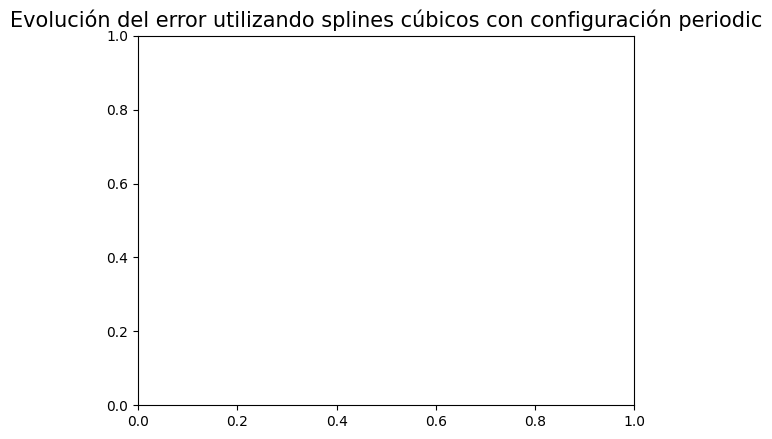

In [56]:
# trayectoria real y la interpolada en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plt.title('Trayectoria real e interpolada')

ax.plot(tray_x_interpolado, tray_y_interpolado, tray_z_interpolado, label='Trayectoria interpolada', color='b',linewidth=2,linestyle='--',alpha=0.7)
ax.plot(tray_x_real, tray_y_real, tray_z_real, label='Trayectoria real', color='r',linestyle='-',linewidth=3,alpha=0.2)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.legend(loc='lower center')
plt.show()
plt.title('Evolución del error utilizando splines cúbicos con configuración ''periodic''', fontsize=15)


Errores:

In [57]:
eval_errores = []
for i in range(len(t_reales)):

    error = np.linalg.norm([
    tray_x_real[i] - tray_x_interpolado[i],
    tray_y_real[i] - tray_y_interpolado[i],
    tray_z_real[i] - tray_z_interpolado[i]])

    eval_errores.append((t_reales[i], error))

# mediana del error 
errores_val = [error for t, error in eval_errores]
mediana_error = round(np.median(errores_val),5)

# error maximo
max_error = round(max(errores_val),5)

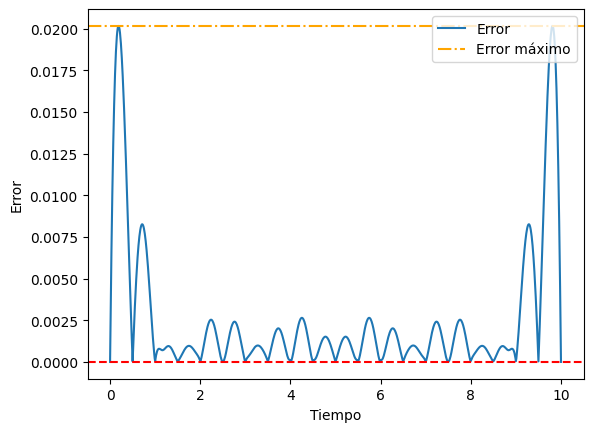

In [58]:
# evolucion del error en el tiempo
t_eval, errores = zip(*eval_errores)
plt.plot(t_eval, errores, label='Error')

plt.xlabel('Tiempo')
plt.ylabel('Error')
plt.axhline(y=0, color='r', linestyle='--')

plt.axhline(y=max_error, color='orange', linestyle='-.', label='Error máximo')  # Asíntota en el error máximo

plt.legend()
plt.legend(loc='upper right')
plt.show()